# 毕业论文`GRAD`
## 要素柱状图

---
*@author: Evan*\
*@date: 2023-12-29*

In [1]:
import os
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import sys
sys.path.append('../../../src/')
from namelist import *
from mask import polygon_to_mask, average_data

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

In [2]:
ds = xr.open_dataset('D:/data/Graduation/OBS/ERA5/monthly.nc')
vars = list(ds.data_vars)

lon1d = ds.longitude
lat1d = ds.latitude
lon, lat = np.meshgrid(lon1d, lat1d,)

shp = gpd.read_file(shp_files['PRD_merge_adm'])
mask = polygon_to_mask(shp.geometry[0], lon, lat)
mask_da = xr.DataArray(mask, dims=('latitude', 'longitude'))

dtime = ds.time
mk = {}
mks = {}
for var in vars:
    mk[var] = ds[var].where(mask_da)
    mks[f'{var}_low_summer'] = mk[var].sel(time=(dtime.dt.year.isin([2014,2015,2016]) & dtime.dt.month.isin([7])))
    mks[f'{var}_low_autumn'] = mk[var].sel(time=(dtime.dt.year.isin([2014,2015,2016]) & dtime.dt.month.isin([9])))
    mks[f'{var}_high_summer'] = mk[var].sel(time=(dtime.dt.year.isin([2019,2021,2022]) & dtime.dt.month.isin([7])))
    mks[f'{var}_high_autumn'] = mk[var].sel(time=(dtime.dt.year.isin([2019,2021,2022]) & dtime.dt.month.isin([9])))

In [3]:
vars = list(ds.data_vars)
flat = {}
for var in vars:
    for period in ['low','high']:
        for season in ['summer','autumn']:
            label = f'{var}_{period}_{season}'
            flat[label] = mks[label].values[~np.isnan(mks[label].values)].flatten()

for period in ['low','high']:
    for season in ['summer','autumn']:
        flat[f't2m_{period}_{season}'] -= 273.15
        flat[f'ssrd_{period}_{season}'] /= 10**6
        
        celsius = flat[f'd2m_{period}_{season}']-273.15
        e = 6.112 * np.exp((17.67 * celsius) / (celsius + 243.5))
        # flat[f'qv_{period}_{season}'] = 1000 * 0.622 * e / (flat[f'sp_{period}_{season}'] - e)
        flat[f'qv_{period}_{season}'] = 1000 * 0.622 * e / (1013.25 - e)
        
        flat[f'wspd_{period}_{season}'] = np.sqrt(flat[f'u10_{period}_{season}']**2 
                                                  + flat[f'v10_{period}_{season}']**2)

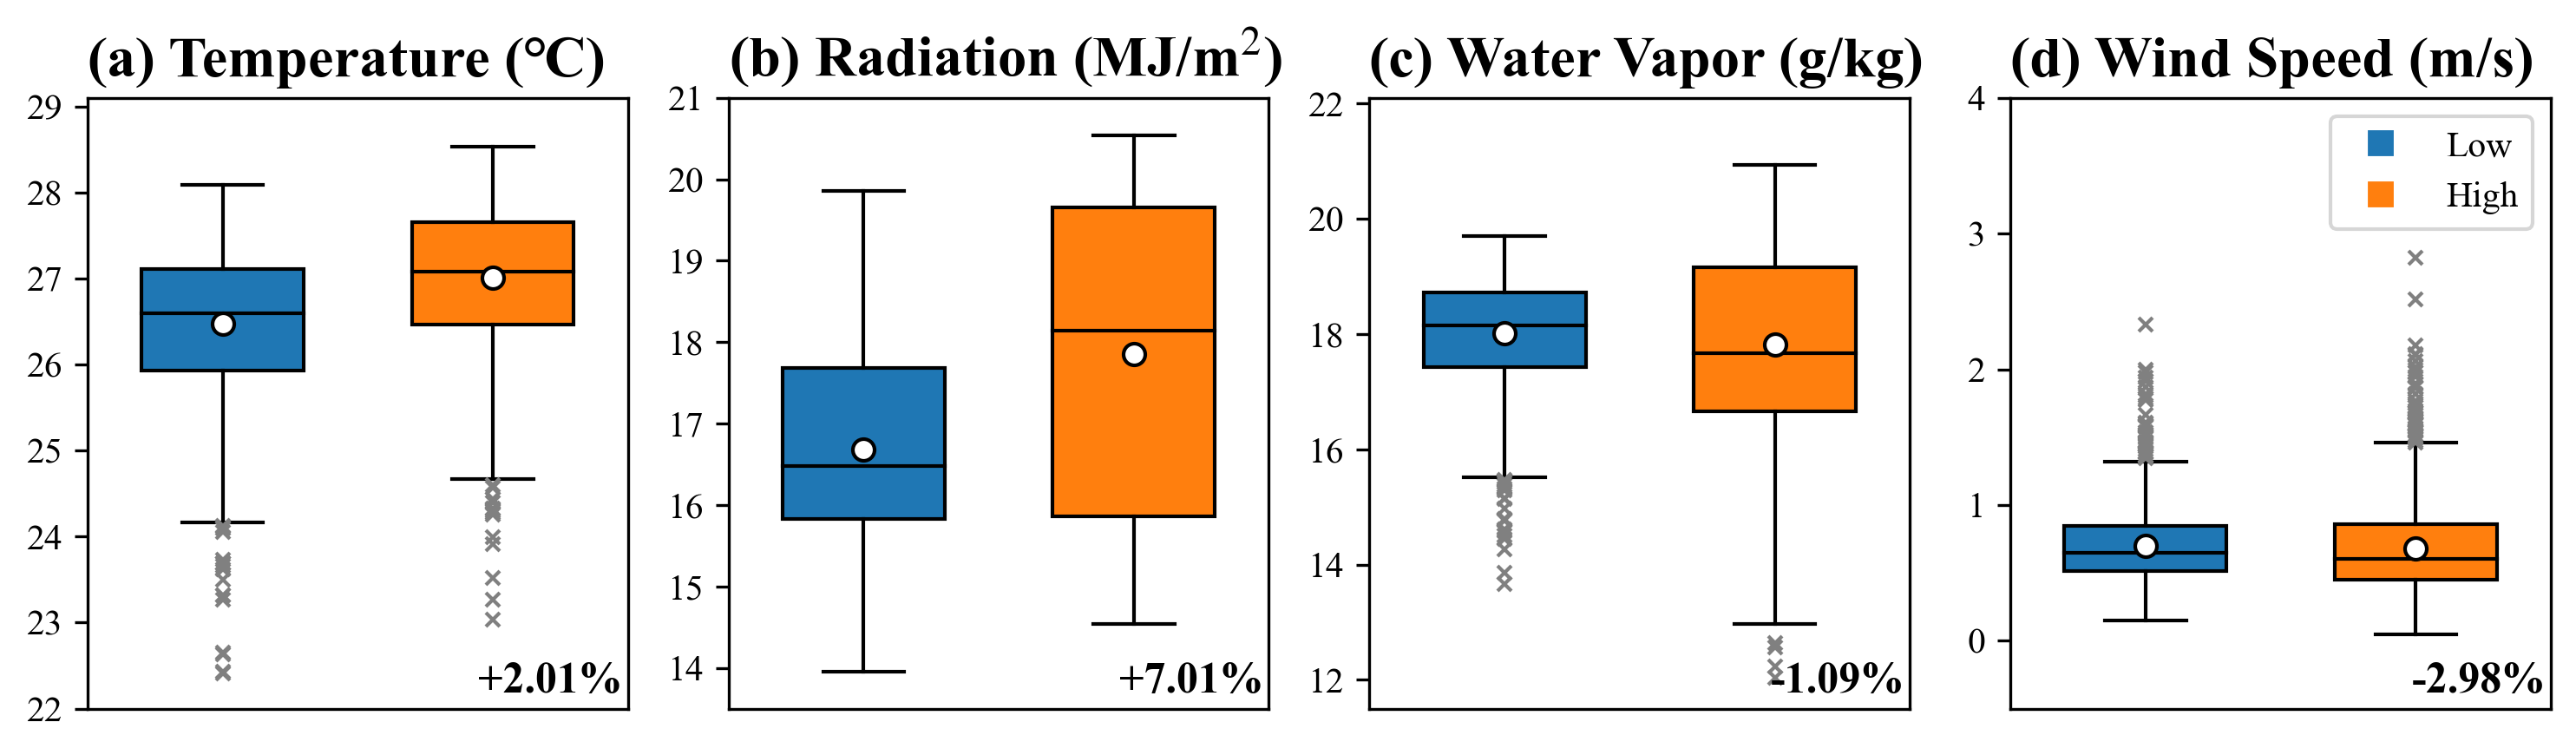

In [4]:
# Plot settings
medianprop = {'linestyle': '-', 'color': 'black'}
flierprop = {'marker': 'x', 'markersize': 4, 'markeredgecolor': 'gray'}
strdict = {'fontsize': 16, 'fontweight': 'bold'}

ylabels = ['Temperature (℃)', 'Radiation (MJ/m$^2$)', 'Water Vapor (g/kg)', 'Wind Speed (m/s)']
ylabeldict = {'fontsize': 12, 'fontweight': 'bold'}
textdict = {'fontsize': 12, 'fontweight': 'bold','ha':'right','va':'bottom'}

vars = ['t2m','ssrd','qv','wspd']
ylimits = {'t2m': [22, 29.1], 'ssrd': [13.5, 21.],
           'qv': [11.5, 22.1], 'wspd': [-0.5, 4]}

# Create subplots
fig, ax = plt.subplots(1, len(vars), figsize=(10, 3), dpi=300)

# Iterate over variables
for i, variable in enumerate(vars):
    box_data = [flat[f'{variable}_low_autumn'], flat[f'{variable}_high_autumn']]

    # Create boxplot
    box = ax[i].boxplot(box_data, patch_artist=True, widths=0.6,
                        medianprops=medianprop, showfliers=True, flierprops=flierprop,
                        showmeans=True,meanprops={'marker':'o','markerfacecolor':'w','markeredgecolor':'black'})

    # Set box colors
    colors = ['tab:blue', 'tab:orange']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # Set subplot title
    ax[i].set_title(f'({chr(97 + i)}) {ylabels[i]}', loc='left', fontdict=strdict)
    ax[i].set_xticks([])
    ax[i].set_ylim(ylimits[variable])
    # ax[i].set_ylabel(ylabels[i], rotation=90, fontdict=ylabeldict)
    
    # Calculate and add percentage change
    percentage_change = ((np.nanmean(box_data[1]) - np.nanmean(box_data[0])) / np.nanmean(box_data[0])) * 100
    # percentage_change = ((np.median(box_data[1]) - np.median(box_data[0])) / np.median(box_data[0])) * 100
    if percentage_change > 0:
        percent = f'+{percentage_change:.2f}%'
    else:
        percent = f'{percentage_change:.2f}%'
    ax[i].text(0.99, 0.01, percent, transform=ax[i].transAxes,**textdict)
    
# Create legend handles and labels
legend_handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=8) for color in ['tab:blue', 'tab:orange']]
legend_labels = ['Low', 'High']
ax[-1].legend(legend_handles, legend_labels,bbox_to_anchor=(1, 1))

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


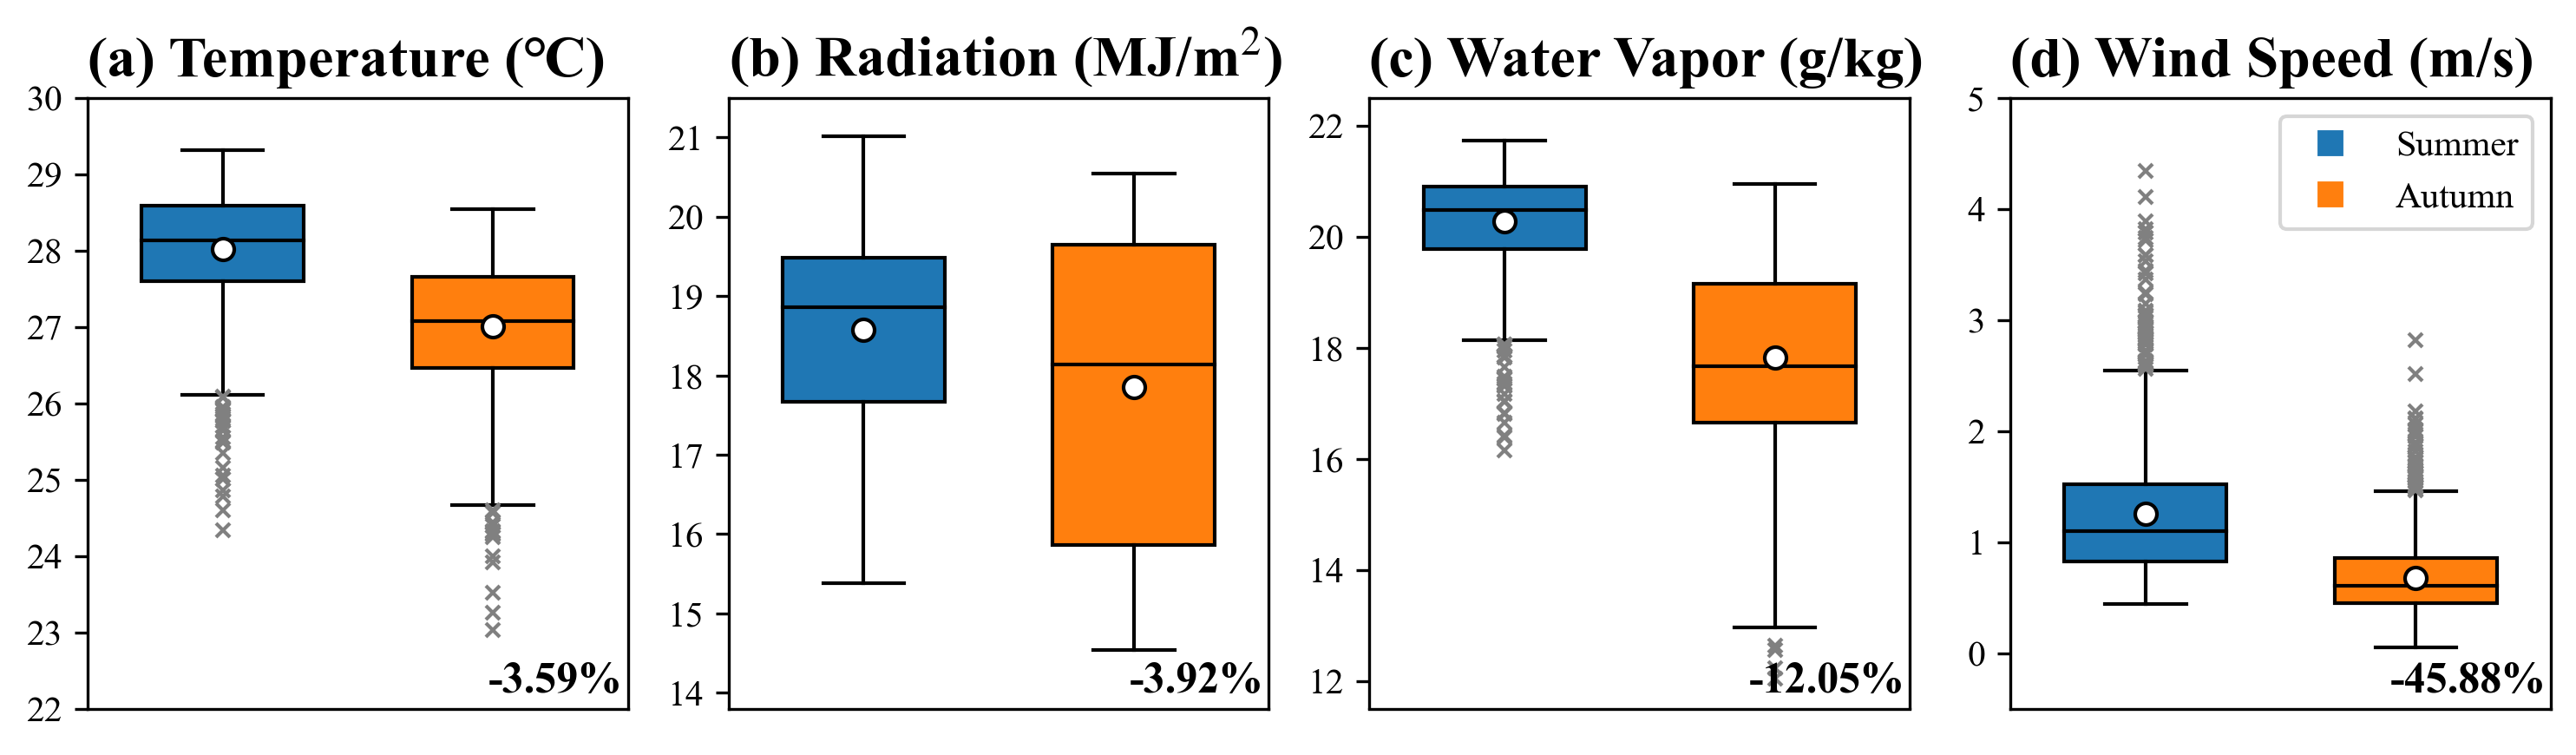

In [5]:
# Plot settings
medianprop = {'linestyle': '-', 'color': 'black'}
flierprop = {'marker': 'x', 'markersize': 4, 'markeredgecolor': 'gray'}
strdict = {'fontsize': 16, 'fontweight': 'bold'}

ylabels = ['Temperature (℃)', 'Radiation (MJ/m$^2$)', 'Water Vapor (g/kg)', 'Wind Speed (m/s)']
ylabeldict = {'fontsize': 12, 'fontweight': 'bold'}
textdict = {'fontsize': 12, 'fontweight': 'bold','ha':'right','va':'bottom'}

vars = ['t2m','ssrd','qv','wspd']
ylimits = {'t2m': [22, 30], 'ssrd': [13.8, 21.5],
           'qv': [11.5, 22.5], 'wspd': [-0.5, 5]}

# Create subplots
fig, ax = plt.subplots(1, len(vars), figsize=(10, 3), dpi=300)

# Iterate over variables
for i, variable in enumerate(vars):
    box_data = [flat[f'{variable}_high_summer'], flat[f'{variable}_high_autumn']]

    # Create boxplot
    box = ax[i].boxplot(box_data, patch_artist=True, widths=0.6,
                        medianprops=medianprop, showfliers=True, flierprops=flierprop,
                        showmeans=True,meanprops={'marker':'o','markerfacecolor':'w','markeredgecolor':'black'})

    # Set box colors
    colors = ['tab:blue', 'tab:orange']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # Set subplot title
    ax[i].set_title(f'({chr(97 + i)}) {ylabels[i]}', loc='left', fontdict=strdict)
    ax[i].set_xticks([])
    ax[i].set_ylim(ylimits[variable])
    # ax[i].set_ylabel(ylabels[i], rotation=90, fontdict=ylabeldict)
    
    # Calculate and add percentage change
    percentage_change = ((np.nanmean(box_data[1]) - np.nanmean(box_data[0])) / np.nanmean(box_data[0])) * 100
    # percentage_change = ((np.median(box_data[1]) - np.median(box_data[0])) / np.median(box_data[0])) * 100
    if percentage_change > 0:
        percent = f'+{percentage_change:.2f}%'
    else:
        percent = f'{percentage_change:.2f}%'
    ax[i].text(0.99, 0.01, percent, transform=ax[i].transAxes,**textdict)
    
# Create legend handles and labels
legend_handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=8) for color in ['tab:blue', 'tab:orange']]
legend_labels = ['Summer', 'Autumn']
ax[-1].legend(legend_handles, legend_labels,bbox_to_anchor=(1, 1))

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
